In [1]:
import pandas as pd
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import tensorflow as tf
import numpy as np

In [11]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [12]:
df = pd.read_csv('data/truncated_df-_1_.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160000 entries, 0 to 159999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   author     160000 non-null  object
 1   body       160000 non-null  object
 2   mbti       160000 non-null  object
 3   disc_type  160000 non-null  object
dtypes: object(4)
memory usage: 4.9+ MB


In [14]:
texts = df["body"].values
labels = df["disc_type"].values

In [15]:
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

In [16]:
import re

def preprocess_text(text):
    # Hilangkan URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Hilangkan angka
    text = re.sub(r'\b\d+\b', '', text)  # Hanya angka yang berdiri sendiri
    # Hilangkan tanda baca
    text = re.sub(r'[^\w\s]', '', text)
    # Ubah ke lowercase
    text = text.lower()
    return text

df['body'] = df['body'].apply(preprocess_text)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [18]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

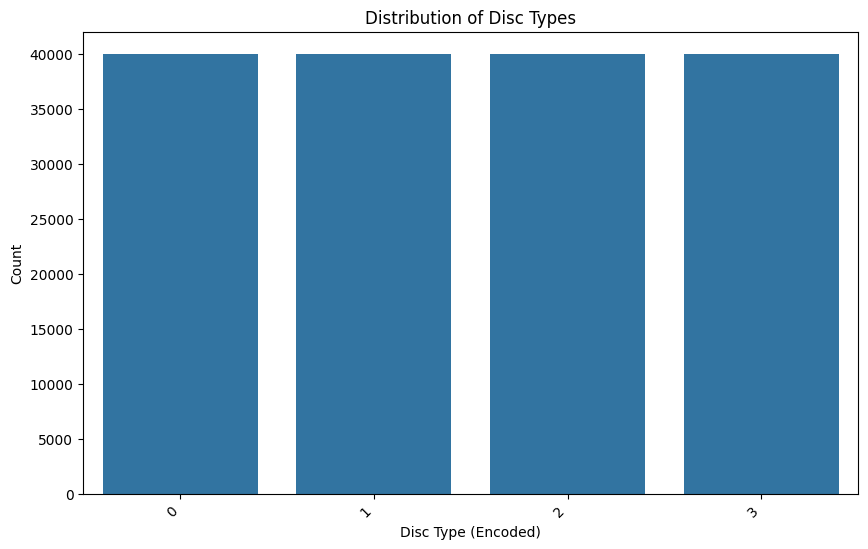

In [71]:
# prompt: show graph from disc types

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'labels' and 'label_encoder' are defined from the previous code
# Count the occurrences of each disc_type
disc_type_counts = pd.Series(labels).value_counts()

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=disc_type_counts.index, y=disc_type_counts.values)
plt.xlabel("Disc Type (Encoded)")
plt.ylabel("Count")
plt.title("Distribution of Disc Types")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

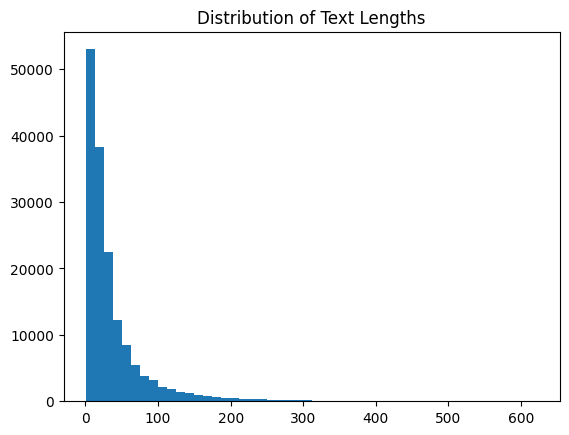

In [19]:
text_lengths = [len(word_tokenize(text)) for text in texts]
import matplotlib.pyplot as plt

plt.hist(text_lengths, bins=50)
plt.title("Distribution of Text Lengths")
plt.show()


In [20]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

In [57]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

In [58]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=256, input_length=100),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')
])


In [59]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_8               │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [61]:
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=5,
    batch_size=32,
    verbose=1,
    # callbacks=[lr_scheduler]
)

Epoch 1/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.2674 - loss: 1.3832 - val_accuracy: 0.2998 - val_loss: 1.3662
Epoch 2/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.3180 - loss: 1.3551 - val_accuracy: 0.3151 - val_loss: 1.3556
Epoch 3/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 88s 15ms/step - accuracy: 0.3601 - loss: 1.3212 - val_accuracy: 0.3184 - val_loss: 1.3576
Epoch 4/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 57s 14ms/step - accuracy: 0.3986 - loss: 1.2794 - val_accuracy: 0.3201 - val_loss: 1.3744
Epoch 5/5
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 56s 14ms/step - accuracy: 0.4350 - loss: 1.2248 - val_accuracy: 0.3169 - val_loss: 1.3988


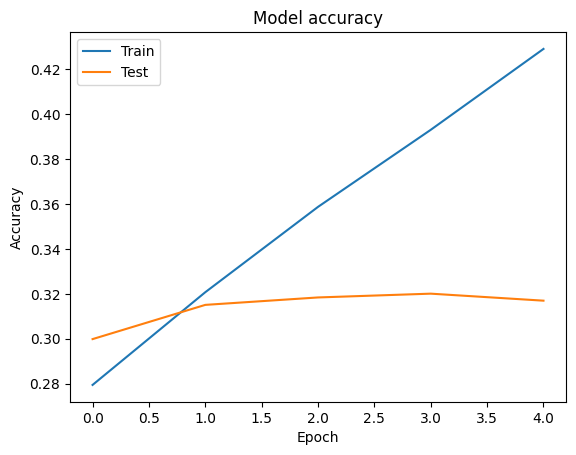

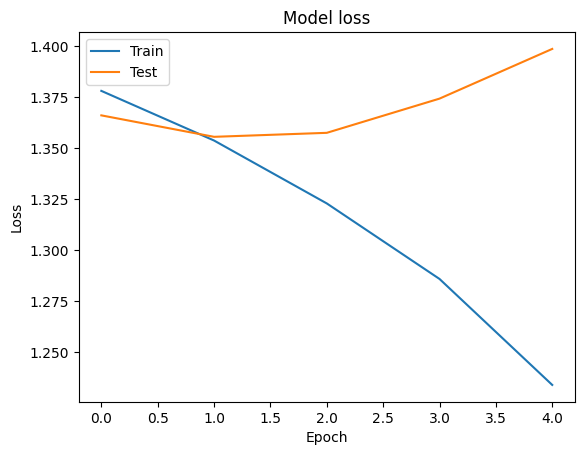

In [62]:
# prompt: visualize train history

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [63]:
model.save('model.h5')

In [64]:
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as json_file:
    json_file.write(tokenizer_json)

In [65]:
import pickle
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [69]:
import tensorflow as tf
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
import numpy as np

# Load the saved model
model = tf.keras.models.load_model('model.h5')

# Load the tokenizer
with open('tokenizer.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

def preprocess_text(text):
    # Hilangkan URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Hilangkan angka
    text = re.sub(r'\b\d+\b', '', text)  # Hanya angka yang berdiri sendiri
    # Hilangkan tanda baca
    text = re.sub(r'[^\w\s]', '', text)
    # Ubah ke lowercase
    text = text.lower()
    return text

def predict_text(text):
    text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=100, padding='post', truncating='post')
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction)
    return predicted_class

# Contoh penggunaan
new_text = "i wonder if jackies involvement with chock full onuts had anything to do with this he was the vice president of the company at one point      edit nevermind its addressed in the video"
predicted_class = predict_text(new_text)
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Predicted class: 2
